# Import Resources

In [181]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import os
import cv2
import random
tfds.disable_progress_bar()

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load the TensorFlow Dataset

In [75]:
train_split = 60
test_val_split = 20

splits = ['train[:60]', 'train[60:80]', 'train[80:]']

dataset, dataset_info = tfds.load('cats_vs_dogs', split = splits, as_supervised = True, with_info = True)

training_set, validation_set, test_set = dataset

# Explore the Dataset

In [87]:
print(dataset_info)
total_examples = dataset_info.splits['train'].num_examples

num_training_examples = (total_examples * 60) // 100
num_validation_examples = (total_examples * 20) // 100
num_test_examples = num_validation_examples

num_classes = dataset_info.features['label'].num_classes

print(f'\nThe dataset has {total_examples} TOTAL images in the dataset')
print(f'\nThe dataset has {num_training_examples} images in the training set')
print(f'The dataset has {num_validation_examples} images in the validation set')
print(f'The dataset has {num_test_examples} images in the test set')
print(f'The dataset has {num_classes} classes')

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

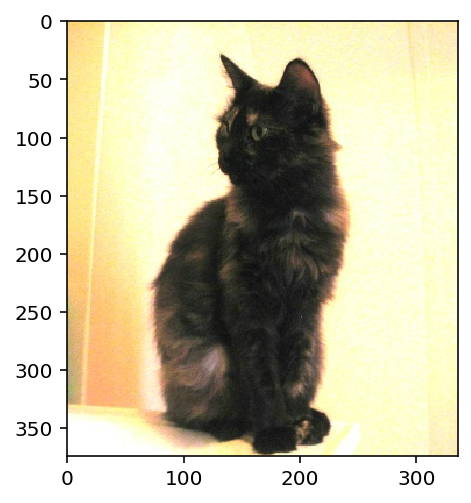

The label of this image is: 0
The class name of this image is: cat


In [88]:
class_names = ['cat', 'dog']

for image, label in training_set.take(1):
    image = image.numpy()
    label = label.numpy()
    
plt.imshow(image)
plt.show()

print(f'The label of this image is: {label}')
print(f'The class name of this image is: {class_names[label]}')

# Create Pipeline

In [103]:
batch_size = 32
image_size = 224

def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label

training_batches = training_set.cache().shuffle(num_training_examples // 4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_set.cache().map(format_image).batch(batch_size).prefetch(1)
testing_batches = test_set.cache().map(format_image).batch(batch_size).prefetch(1)

# Import Pre-Trained Model

In [104]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape = (image_size, image_size, 3))

feature_extractor.trainable = False

# Build the Model

In [105]:
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(128, activation = 'relu'), 
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dense(2, activation = 'softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_7 (Dense)              (None, 128)               163968    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 66        
Total params: 2,432,354
Trainable params: 174,370
Non-trainable params: 2,257,984
_________________________________________________________________


# Train the Model on the Dataset

In [106]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

EPOCHS = 10

history = model.fit(training_batches, epochs = EPOCHS, validation_data = validation_batches)

Epoch 1/10
2/2 [==============================] 0.6794 - accuracy: 0.65 - 6s 3s/step - loss: 0.7223 - accuracy: 0.53 - 7s 3s/step - loss: 0.7213 - accuracy: 0.5333 - val_loss: 0.3548 - val_accuracy: 0.9500
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 0.3869 - accuracy: 0.87 - 2s 1s/step - loss: 0.3382 - accuracy: 0.9000 - val_loss: 0.1985 - val_accuracy: 0.9500
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 1.00 - 2s 1s/step - loss: 0.1288 - accuracy: 1.0000 - val_loss: 0.0838 - val_accuracy: 0.9500
Epoch 4/10
2/2 [==============================] - ETA: 0s - loss: 0.0821 - accuracy: 1.00 - 2s 1s/step - loss: 0.0526 - accuracy: 1.0000 - val_loss: 0.0584 - val_accuracy: 0.9500
Epoch 5/10
2/2 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 1.00 - 2s 1s/step - loss: 0.0254 - accuracy: 1.0000 - val_loss: 0.0427 - val_accuracy: 0.9500
Epoch 6/10
2/2 [==============================] - ETA: 0s - loss: 0.0154 - acc

# Plot of the Loss and Accuracy for Training and Validation Set

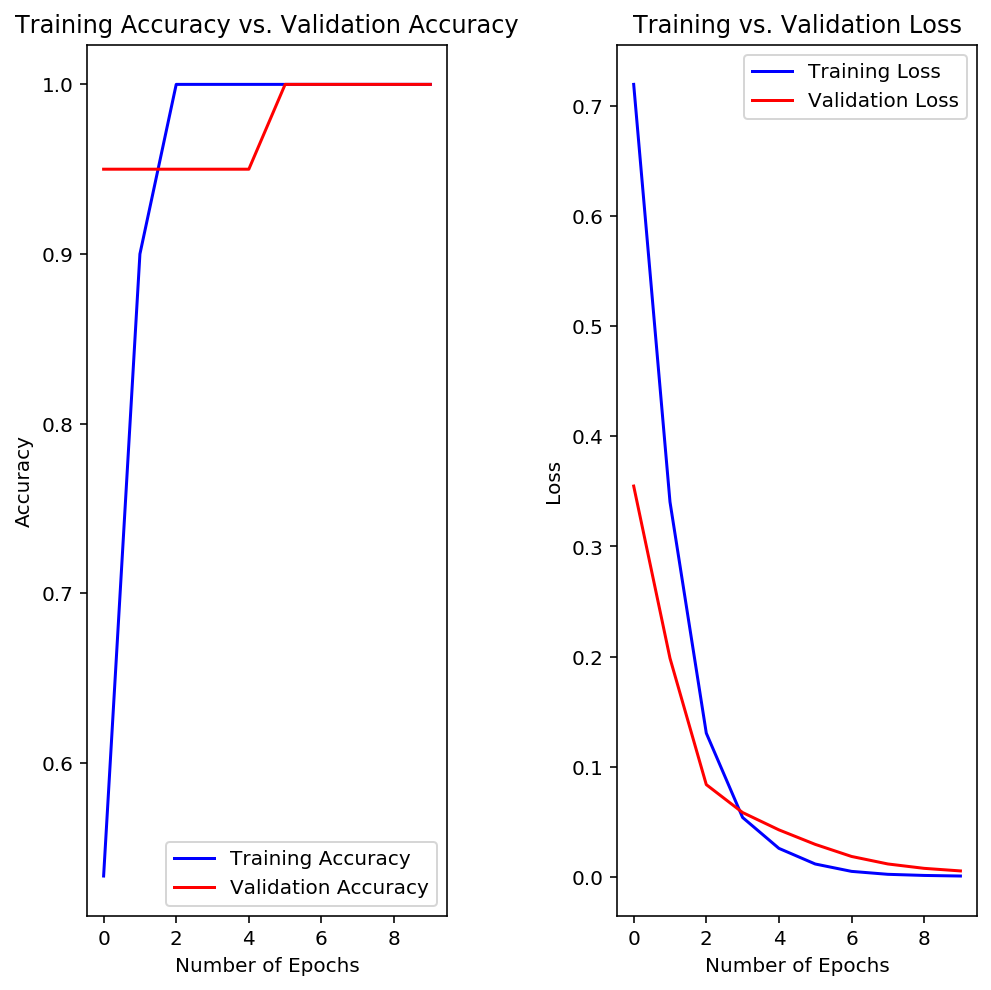

In [111]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

fig, (ax1, ax2) = plt.subplots(figsize = (7,7), nrows = 1, ncols = 2)
ax1.plot(epochs_range, training_accuracy, color = 'b', label = 'Training Accuracy')
ax1.plot(epochs_range, validation_accuracy, color = 'r', label = 'Validation Accuracy')
ax1.set(title = 'Training Accuracy vs. Validation Accuracy', 
        xlabel = 'Number of Epochs', 
        ylabel = 'Accuracy')
ax1.legend(loc = 'best')

ax2.plot(epochs_range, training_loss, color = 'b', label = 'Training Loss')
ax2.plot(epochs_range, validation_loss, color = 'r', label = 'Validation Loss')
ax2.set(title = 'Training vs. Validation Loss', 
        xlabel = 'Number of Epochs', 
        ylabel = 'Loss')
ax2.legend(loc = 'best')
fig.tight_layout()

# Test the Network

In [113]:
loss, accuracy = model.evaluate(testing_batches)

print(f'\nThe loss on the test set is: {loss:.3f}')
print(f'The accuracy on the test set is: {accuracy:.3%}')

    166/Unknown - 2s 2s/step - loss: 0.0443 - accuracy: 0.96 - 3s 1s/step - loss: 0.0250 - accuracy: 0.98 - 4s 1s/step - loss: 0.0270 - accuracy: 0.98 - 4s 1s/step - loss: 0.0772 - accuracy: 0.97 - 5s 1s/step - loss: 0.0681 - accuracy: 0.97 - 6s 1s/step - loss: 0.0648 - accuracy: 0.97 - 7s 983ms/step - loss: 0.0558 - accuracy: 0.977 - 8s 969ms/step - loss: 0.0514 - accuracy: 0.980 - 9s 953ms/step - loss: 0.0714 - accuracy: 0.972 - 9s 943ms/step - loss: 0.0855 - accuracy: 0.971 - 10s 929ms/step - loss: 0.0780 - accuracy: 0.97 - 11s 919ms/step - loss: 0.0718 - accuracy: 0.97 - 12s 914ms/step - loss: 0.0664 - accuracy: 0.97 - 13s 906ms/step - loss: 0.0622 - accuracy: 0.97 - 14s 903ms/step - loss: 0.0606 - accuracy: 0.97 - 14s 896ms/step - loss: 0.0677 - accuracy: 0.97 - 15s 891ms/step - loss: 0.0674 - accuracy: 0.97 - 16s 886ms/step - loss: 0.0645 - accuracy: 0.97 - 17s 882ms/step - loss: 0.0636 - accuracy: 0.97 - 18s 878ms/step - loss: 0.0747 - accuracy: 0.97 - 18s 873ms/step - loss: 0.0

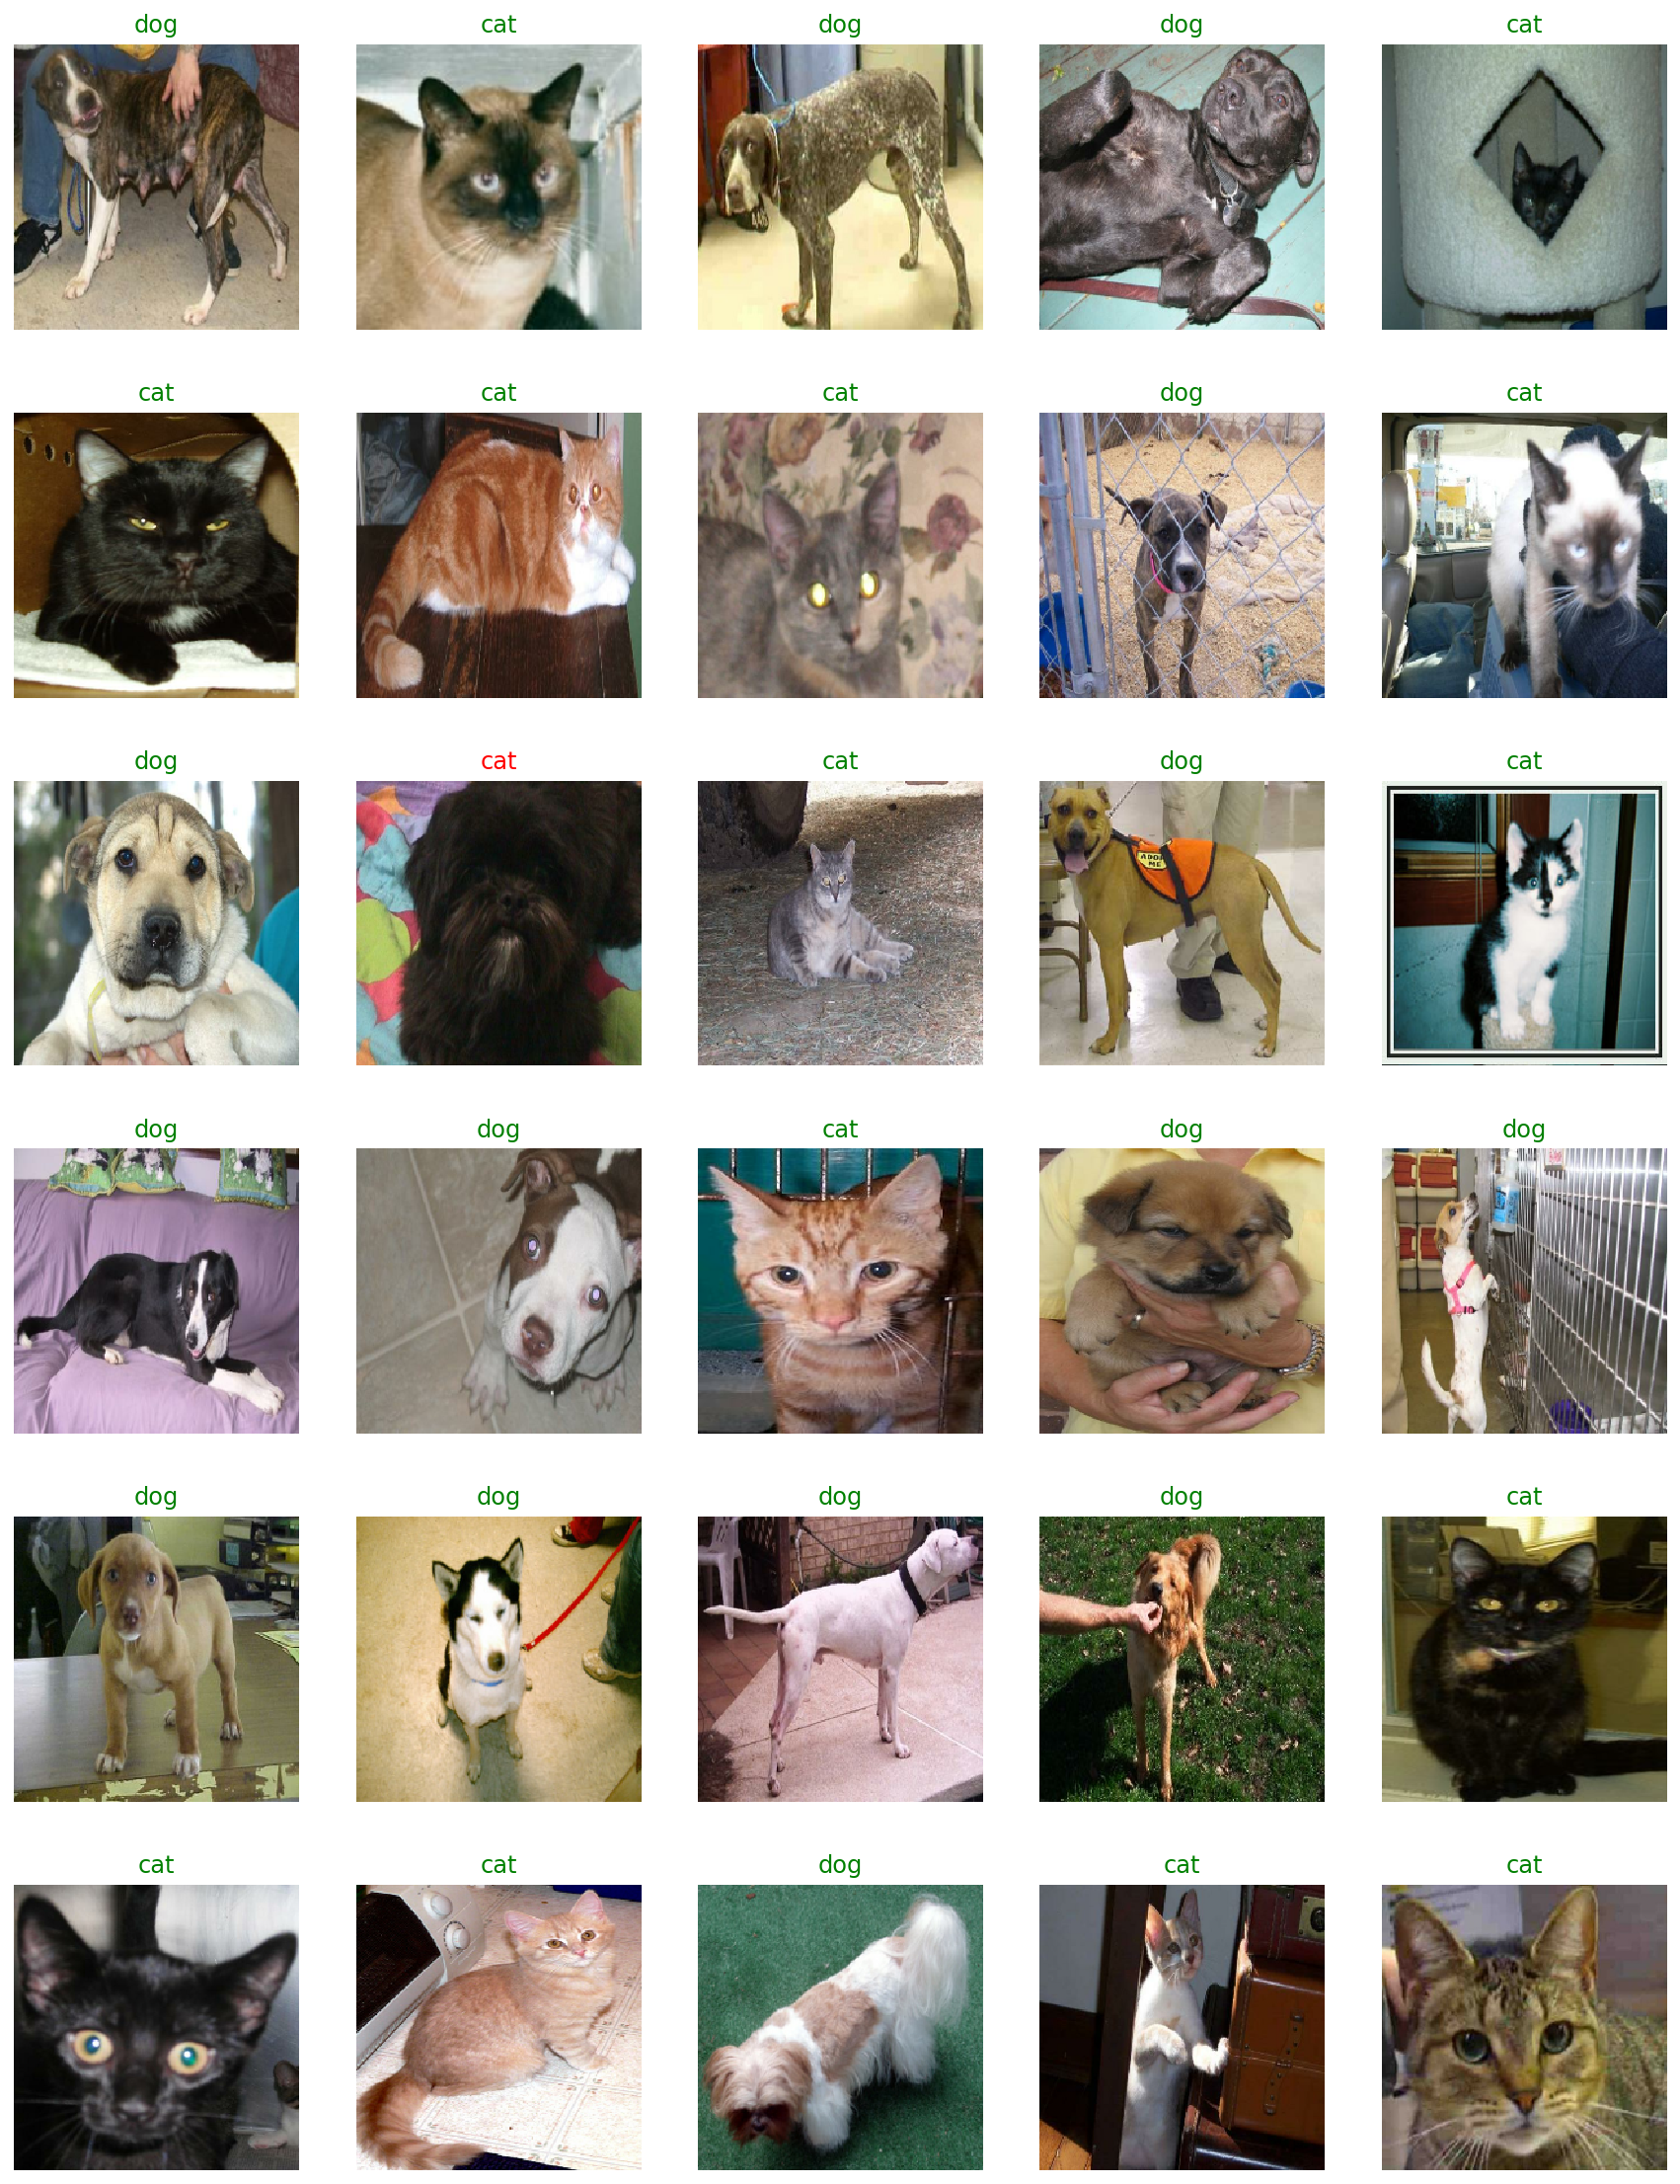

In [122]:
for image_batch, label_batch in testing_batches.take(1):
    ps = model.predict(image_batch)
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()
    
plt.figure(figsize = (15,20))

for n in range(30):
    plt.subplot(6, 5, n + 1)
    plt.imshow(images[n])
    color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
    plt.title(class_names[np.argmax(ps[n])], color=color)
    plt.axis('off')

In [123]:
# Save the model
import time

t = time.time()
saved_model_filepath = './my_model.h5'.format(int(t))
model.save(saved_model_filepath, overwrite = False)

# Inference and Pre-Processing

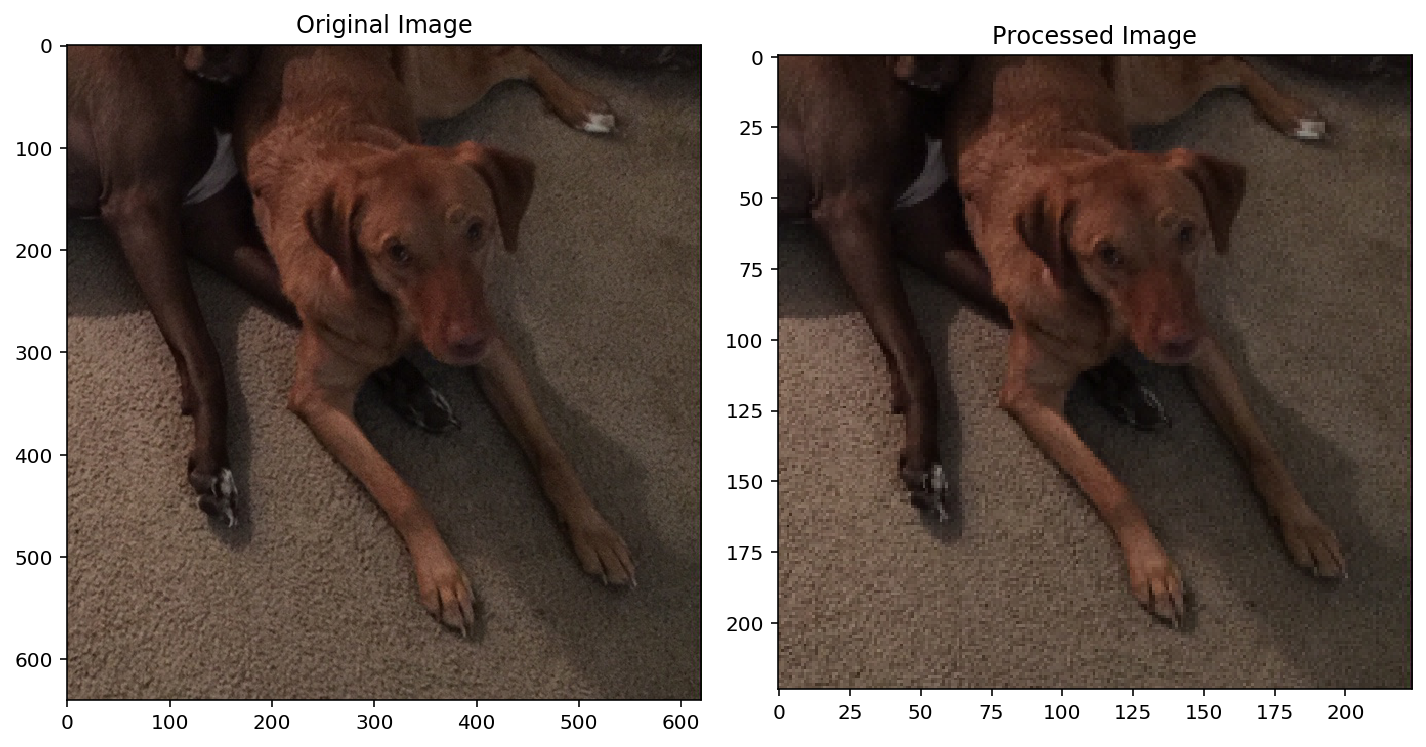


The size of the processed image is (224, 224, 3)


In [154]:
from PIL import Image

def process_image(image):
    image = tf.convert_to_tensor(image)
    image = tf.image.resize(image, size = (image_size, image_size))
    image /= 255
    image = image.numpy()
    return image

image_path = 'C:/Users/josep/Desktop/ECE/Spring 2020/ECE 523/Project/sierra.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize = (10,10), ncols = 2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

print(f'\nThe size of the processed image is {processed_test_image.shape}')

In [155]:
def predict(image_path, model, top_k):
    image = Image.open(image_path)
    image = np.asarray(image)
    image = process_image(image)
    image = np.expand_dims(image, axis = 0)
    prob_predictions = model.predict(image)
    prob_predictions = prob_predictions[0].tolist()
    values, indices = tf.math.top_k(prob_predictions, k = top_k)
    probs = values.numpy().tolist()
    classes = indices.numpy().tolist()
    print(f'\nThe probability that the image is a {class_names[classes[0]]} is {probs[0]:.3%}')
    print(f'The probability that the image is a {class_names[classes[1]]} is {probs[1]:.3%}')
    return probs, classes

predict(image_path, model, 2)


The probability that the image is a dog is 99.980%
The probability that the image is a cat is 0.020%


([0.9998039603233337, 0.00019607138528954238], [1, 0])


The probability that the image is a dog is 99.980%
The probability that the image is a cat is 0.020%


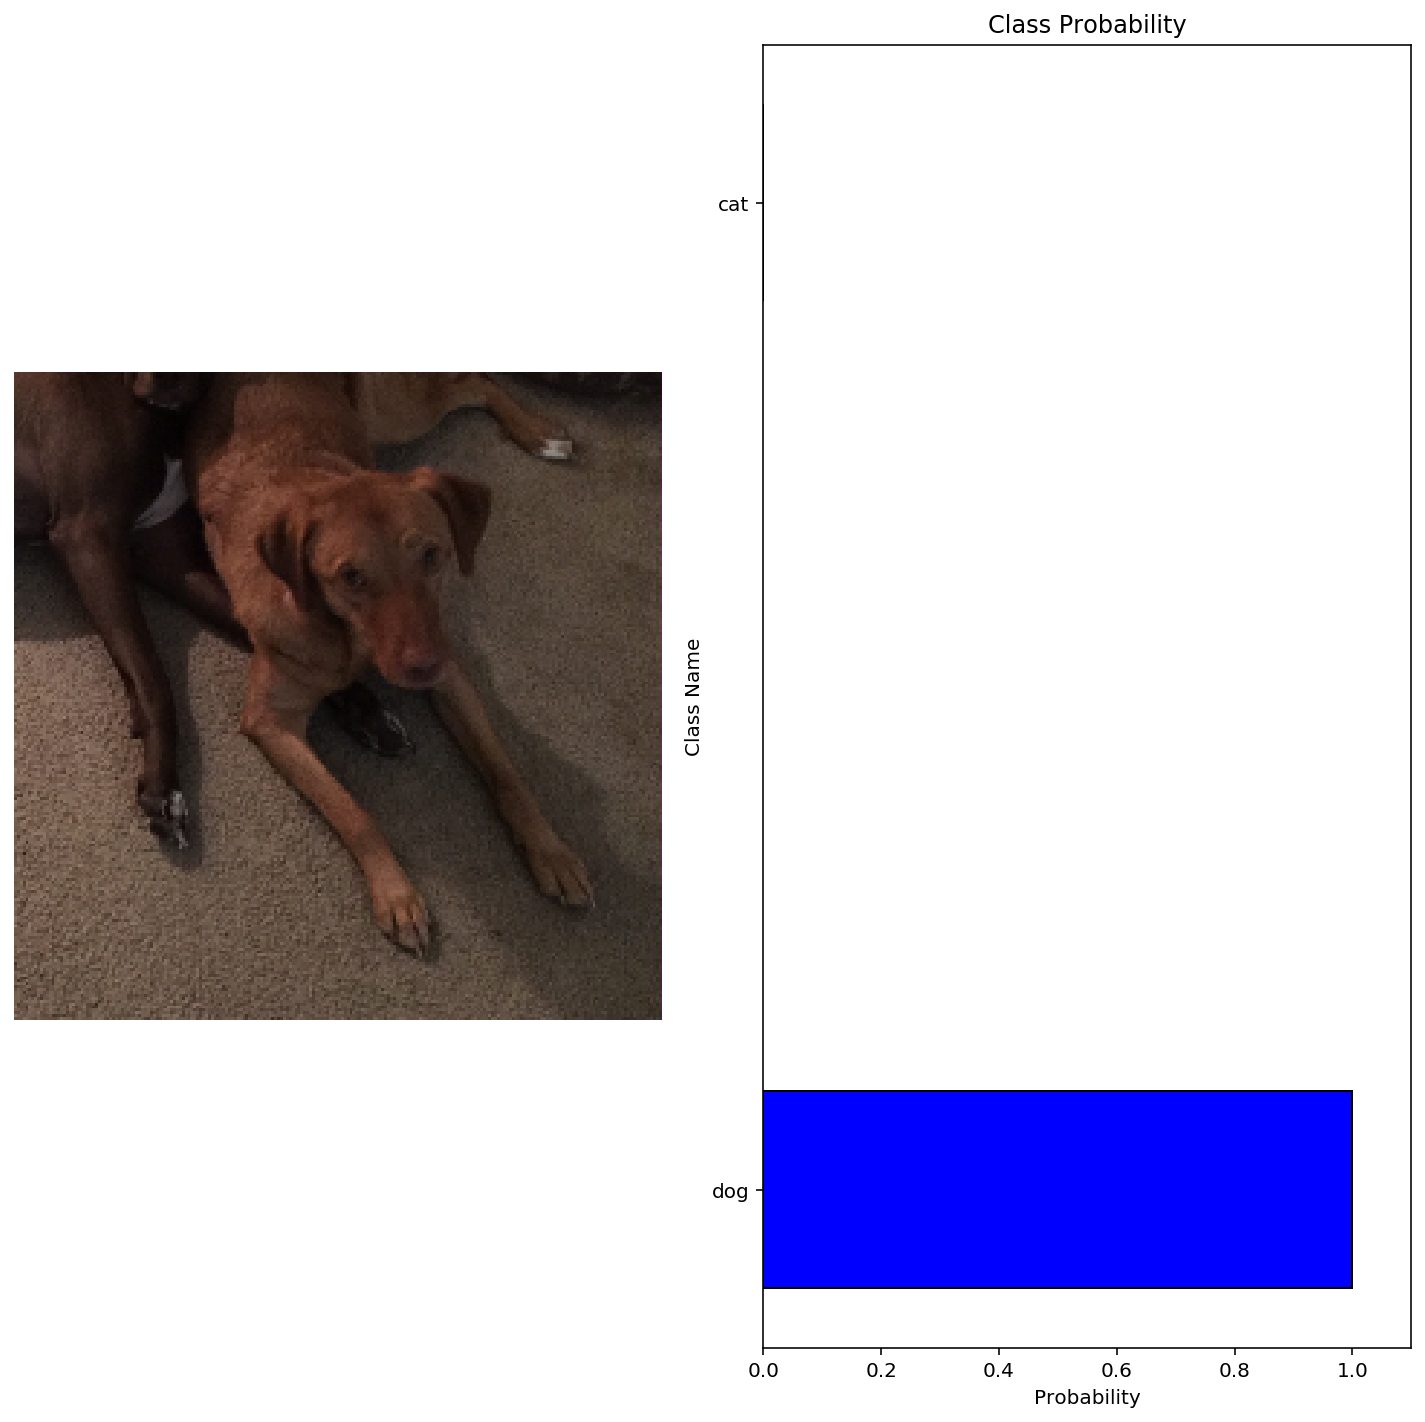

In [156]:
# Sanity Check
probs, classes = predict(image_path, model, 2)

names = []
for i in classes:
    names.append(class_names[i])
    
processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize = (10, 10), nrows = 1, ncols = 2)
ax1.imshow(processed_test_image)
ax1.axis('off')

ax2.barh(names, probs, color = 'blue', edgecolor = 'k', height = 0.2)
ax2.set(title = 'Class Probability', xlabel = 'Probability', ylabel = 'Class Name')
ax2.set_xlim(0, 1.1)
plt.tight_layout()